# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

In [1]:
!cd /volume
import os
os.chdir('/volume')

## Imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from util import load_image_into_numpy_array, plot_detections

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.core.preprocessor import random_horizontal_flip, random_vertical_flip, random_rotation90, random_distort_color, ssd_random_crop
import object_detection
# from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [3]:
def show_all_boxes():
    for i, image in enumerate(train_images_np):
        boxes = gt_boxes[i]
        for box in boxes:
            print(box)
            plt.plot()
            plt.imshow(image)
            break
        break

# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [4]:
LABEL_FILE = "data/labels_setter_2022-02-23-01-41-47.json"
import json
with open(LABEL_FILE) as f:
    labels = json.load(f)
# gt_boxes = [
#             np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
#             np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
#             np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
#             np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
#             np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
# ]
print(json.dumps(labels['annotations'][1], indent=4))
image_id_map = {l['id'] : l for l in labels['images']}
def convert(l):
    im = image_id_map[l['image_id']]
    width = im['width']
    height = im['height']
    a, b, c, d = l['bbox']
    # x, y, width, height
    c += a
    d += b
    a, b, c, d = a/width, b/height, c/width, d/height
    assert all([a<=1, b<=1, c<=1, d<=1]), l
    return np.array([b, a, d, c], dtype=np.float32)

{
    "id": 1,
    "iscrowd": 0,
    "image_id": 1,
    "category_id": 1,
    "segmentation": [
        [
            233.19824856474577,
            327.17739743962255,
            322.3026171744921,
            366.10649052155054,
            233.19824856474577,
            514.9021351902533,
            135.44297038123764,
            468.18722349193956
        ]
    ],
    "bbox": [
        135.44297038123764,
        327.17739743962255,
        186.85964679325448,
        187.7247377506307
    ],
    "area": 17539.0890952196
}


In [5]:
# Load images and visualize
def load_data():
  train_image_dir = 'data/train'
  train_images_np = []
  gt_boxes = []
  for image in labels['images']:
    image_path = os.path.join(train_image_dir, image['file_name'])
    try:
      train_images_np.append(load_image_into_numpy_array(image_path))
      gt_boxes.append([])
      for l in labels['annotations']:
        if l['image_id'] != image['id']:
          continue
        gt_boxes[-1].append(convert(l))
    except Exception:
      pass
  gt_boxes = [np.stack(g) for g in gt_boxes]
  assert len(train_images_np) == len(gt_boxes)
  return train_images_np, gt_boxes

train_images_np, gt_boxes = load_data()

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [6]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'card'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Let's just visualize the rubber duckies as a sanity check


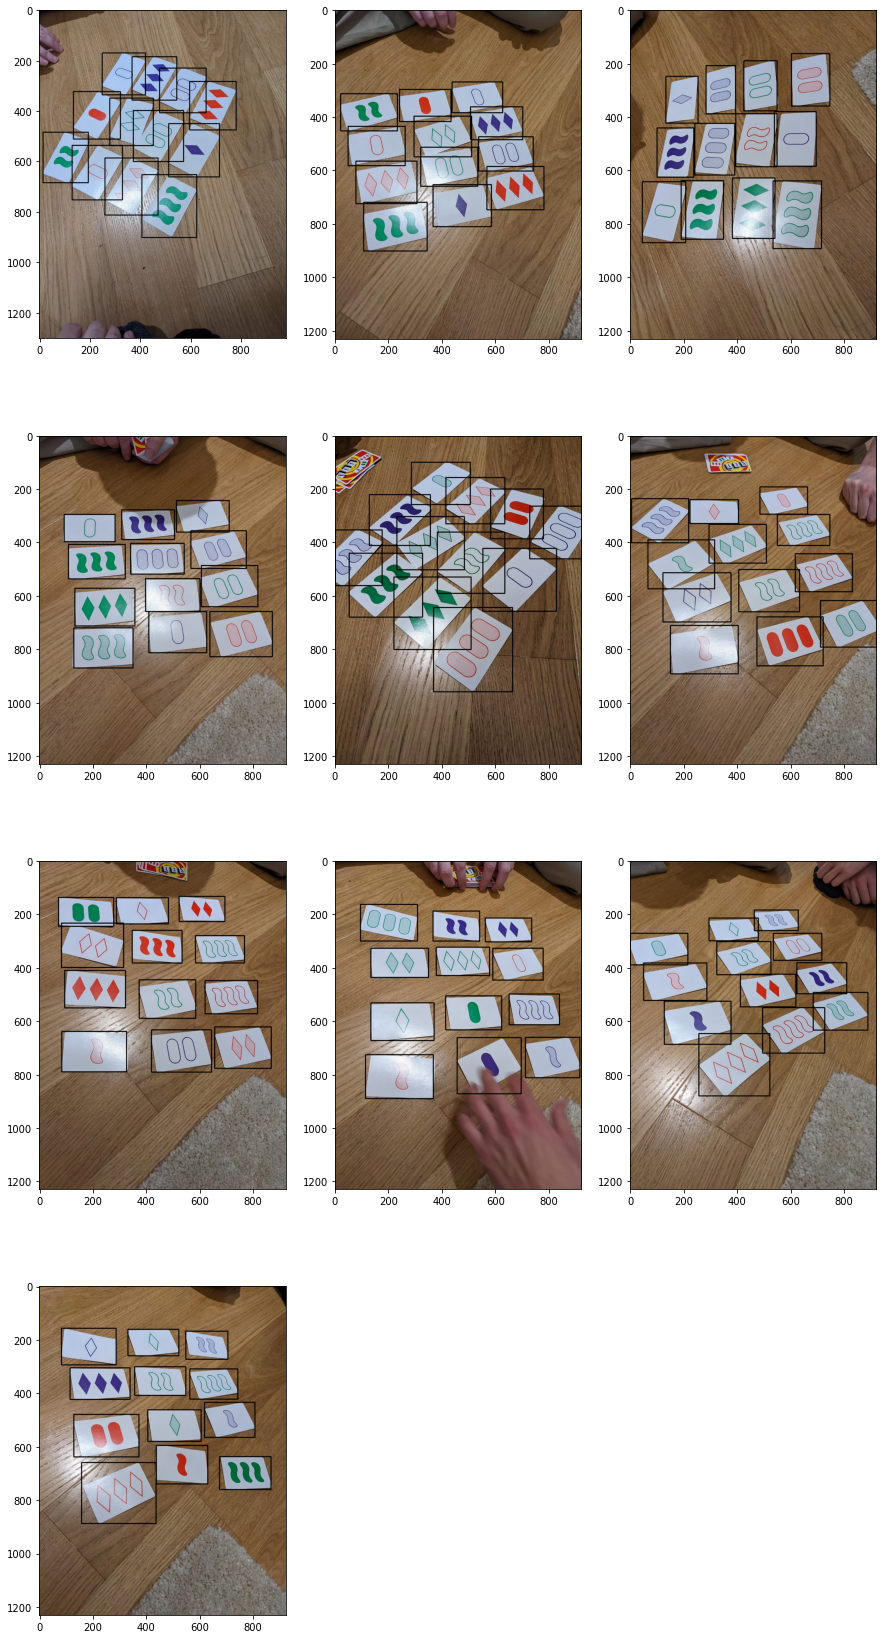

In [7]:
def plot_boxes(images, boxes):
  assert isinstance(images, list)
  assert isinstance(boxes, list)
  fig = plt.figure(figsize=(15,30))
  assert len(images[0].shape) == 3
  for idx in range(len(images)):
    ax = fig.add_subplot(4, 3, idx+1)
    plot_detections(
        images[idx],
        boxes[idx],
        np.ones(shape=[boxes[idx].shape[0]], dtype=np.int32),
        None, 
        category_index,
        ax=ax,
      )
plot_boxes(train_images_np, gt_boxes)

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [8]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
MODEL_NAME = "ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8"

In [9]:
SIZE = (640, 640)

def build_and_restore_model():
    tf.keras.backend.clear_session()
    print('Building model and restoring weights for fine-tuning...', flush=True)
    num_classes = 1
    pipeline_config = f'/home/tensorflow/models/research/object_detection/configs/tf2/{MODEL_NAME}.config'
    checkpoint_path = '/home/tensorflow/models/research/object_detection/test_data/checkpoint/ckpt-0'
    
    # Load pipeline config and build a detection model.
    #
    # Since we are working off of a COCO architecture which predicts 90
    # class slots by default, we override the `num_classes` field here to be just
    # one (for our new rubber ducky class).
    configs = config_util.get_configs_from_pipeline_file(pipeline_config)
    model_config = configs['model']
    # print(model_config.centure_net.feature_extractor)
    model_config.ssd.num_classes = num_classes
    model_config.ssd.freeze_batchnorm = True
    nms = model_config.ssd.post_processing.batch_non_max_suppression
    nms.iou_threshold = 0.4
    nms.max_detections_per_class = 26
    nms.max_total_detections = 26
    detection_model = model_builder.build(
          model_config=model_config, is_training=True)
    
    # Set up object-based checkpoint restore --- RetinaNet has two prediction
    # `heads` --- one for classification, the other for box regression.  We will
    # restore the box regression head but initialize the classification head
    # from scratch (we show the omission below by commenting out the line that
    # we would add if we wanted to restore both heads)
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
        _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
        # _prediction_heads=detection_model._box_predictor._prediction_heads,
        #    (i.e., the classification head that we *will not* restore)
        _box_prediction_head=detection_model._box_predictor._box_prediction_head,
        )
    fake_model = tf.compat.v2.train.Checkpoint(
              _feature_extractor=detection_model._feature_extractor,
              _box_predictor=fake_box_predictor)
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(checkpoint_path).expect_partial()
    
    # Run model through a dummy image so that variables are created
    image, shapes = detection_model.preprocess(tf.zeros([1, *SIZE, 3]))
    prediction_dict = detection_model.predict(image, shapes)
    _ = detection_model.postprocess(prediction_dict, shapes)
    print('Weights restored!')
    return detection_model

detection_model = build_and_restore_model()

Building model and restoring weights for fine-tuning...


ValueError: max_detections_per_class should be no greater than max_total_detections.

# Eager mode custom training loop



In [ ]:
for v in sorted(set(i.name.split('/')[0] for i in detection_model.trainable_variables)):
    print(v)

Conv1
Conv_1
Conv_1_bn
WeightSharedConvolutionalBoxPredictor
block_10_depthwise
block_10_depthwise_BN
block_10_expand
block_10_expand_BN
block_10_project
block_10_project_BN
block_11_depthwise
block_11_depthwise_BN
block_11_expand
block_11_expand_BN
block_11_project
block_11_project_BN
block_12_depthwise
block_12_depthwise_BN
block_12_expand
block_12_expand_BN
block_12_project
block_12_project_BN
block_13_depthwise
block_13_depthwise_BN
block_13_expand
block_13_expand_BN
block_13_project
block_13_project_BN
block_14_depthwise
block_14_depthwise_BN
block_14_expand
block_14_expand_BN
block_14_project
block_14_project_BN
block_15_depthwise
block_15_depthwise_BN
block_15_expand
block_15_expand_BN
block_15_project
block_15_project_BN
block_16_depthwise
block_16_depthwise_BN
block_16_expand
block_16_expand_BN
block_16_project
block_16_project_BN
block_1_depthwise
block_1_depthwise_BN
block_1_expand
block_1_expand_BN
block_1_project
block_1_project_BN
block_2_depthwise
block_2_depthwise_BN
bl

In [ ]:
def train(detection_model):
  tf.keras.backend.set_learning_phase(True)

  # These parameters can be tuned; since our training set has 5 images
  # it doesn't make sense to have a much larger batch size, though we could
  # fit more examples in memory if we wanted to.
  batch_size = len(train_images_np)
  learning_rate = 0.001
  num_batches = 1500

  # Select variables in top layers to fine-tune.
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor',
    'ssd_mobile_net_v2_fpn_keras_feature_extractor',
  ]
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  # print("Tuning", [v.name for v in to_fine_tune])

  # to_fine_tune = trainable_variables  # Fine tune everything

  # Set up forward + backward pass for a single train step.
  def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
      """A single training iteration.

      Args:
        image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
          Note that the height and width can vary across images, as they are
          reshaped within this function to be 640x640.
        groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
          tf.float32 representing groundtruth boxes for each image in the batch.
        groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
          with type tf.float32 representing groundtruth boxes for each image in
          the batch.

      Returns:
        A scalar tensor representing the total loss for the input batch.
      """
      shapes = tf.constant(batch_size * [[*SIZE, 3]], dtype=tf.int32)
      model.provide_groundtruth(
          groundtruth_boxes_list=groundtruth_boxes_list,
          groundtruth_classes_list=groundtruth_classes_list)
      with tf.GradientTape() as tape:
        preprocessed_images = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
             for image_tensor in image_tensors], axis=0)
        prediction_dict = model.predict(preprocessed_images, shapes)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
      return total_loss

    return train_step_fn

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
  train_step_fn = get_model_train_step_function(
      detection_model, optimizer, to_fine_tune)

  def random_crop_image(im, boxes, classes, weights):
      assert len(im.shape) == 3, im.shape
      im, boxes, classes, weights = object_detection.core.preprocessor.random_crop_image(im, boxes, classes, weights)
      return im, boxes, classes, weights

  print('Start fine-tuning!', flush=True)
  def data_gen():
    aug_image_tensors = list(train_image_tensors)
    aug_box_tensors = list(gt_box_tensors)
    aug_classes_one_hot_tensors = list(gt_classes_one_hot_tensors)
    for i, image in enumerate(aug_image_tensors):
      image = tf.image.resize(image, SIZE)
      image = random_distort_color(image[0])
      # image, aug_box_tensors[i], aug_classes_one_hot_tensors[i], _ = random_crop_image(image, aug_box_tensors[i], aug_classes_one_hot_tensors[i], aug_classes_one_hot_tensors[i])
      image, aug_box_tensors[i] = random_horizontal_flip(image, aug_box_tensors[i])
      image, aug_box_tensors[i] = random_vertical_flip(image, aug_box_tensors[i])
      image, aug_box_tensors[i] = random_rotation90(image, aug_box_tensors[i])
      image = tf.expand_dims(image, 0)
      aug_image_tensors[i] = image
    return aug_image_tensors, aug_box_tensors, aug_classes_one_hot_tensors

  for idx in range(num_batches):
    # Grab keys for a random subset of examples
    # all_keys = list(range(len(train_images_np)))
    # random.shuffle(all_keys)
    # example_keys = all_keys[:batch_size]

    # # Note that we do not do data augmentation in this demo.  If you want a
    # # a fun exercise, we recommend experimenting with random horizontal flipping
    # # and random cropping :)
    # gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    # gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    # image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)

    # Apply augmentations
    aug_image_tensors, aug_box_tensors, aug_classes_one_hot_tensors = data_gen()

    # plot_boxes([n.numpy().astype(np.uint8)[0] for n in aug_image_tensors], [n.numpy() for n in aug_box_tensors])
    total_loss = train_step_fn(aug_image_tensors, aug_box_tensors, aug_classes_one_hot_tensors)

    if idx % 10 == 0:
      print('batch ' + str(idx) + ' of ' + str(num_batches)
      + ', loss=' +  str(total_loss.numpy()), flush=True)

  print('Done fine-tuning!')

train(detection_model)

Start fine-tuning!


/usr/local/lib/python3.8/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 1500, loss=1.3432914
batch 10 of 1500, loss=1.2744852
batch 20 of 1500, loss=1.2033467
batch 30 of 1500, loss=1.1953312
batch 40 of 1500, loss=1.1635816
batch 50 of 1500, loss=1.1173984
batch 60 of 1500, loss=1.0720055
batch 70 of 1500, loss=1.0253502
batch 80 of 1500, loss=0.94288313
batch 90 of 1500, loss=0.75265265
batch 100 of 1500, loss=0.72769034
batch 110 of 1500, loss=0.6458311
batch 120 of 1500, loss=0.5311595
batch 130 of 1500, loss=0.52531636
batch 140 of 1500, loss=0.5105221
batch 150 of 1500, loss=0.45287865
batch 160 of 1500, loss=0.48763394
batch 170 of 1500, loss=0.42887315
batch 180 of 1500, loss=0.38227475
batch 190 of 1500, loss=0.38618204
batch 200 of 1500, loss=0.34950787
batch 210 of 1500, loss=0.32387793
batch 220 of 1500, loss=0.3439189
batch 230 of 1500, loss=0.32826036
batch 240 of 1500, loss=0.29455695
batch 250 of 1500, loss=0.29253826
batch 260 of 1500, loss=0.27718768
batch 270 of 1500, loss=0.2619911
batch 280 of 1500, loss=0.2617022
batch 290 

KeyboardInterrupt: 

# Load test images and run inference with new model!

data/test/Deskohraní_2012_-_6831.JPG
data/test/PXL_20220223_015339635.MP.jpg
{'detection_boxes': TensorShape([1, 100, 4]), 'detection_scores': TensorShape([1, 100]), 'detection_classes': TensorShape([1, 100]), 'num_detections': TensorShape([1]), 'raw_detection_boxes': TensorShape([1, 51150, 4]), 'raw_detection_scores': TensorShape([1, 51150, 2]), 'detection_multiclass_scores': TensorShape([1, 100, 2]), 'detection_anchor_indices': TensorShape([1, 100])}
{'detection_boxes': TensorShape([1, 100, 4]), 'detection_scores': TensorShape([1, 100]), 'detection_classes': TensorShape([1, 100]), 'num_detections': TensorShape([1]), 'raw_detection_boxes': TensorShape([1, 51150, 4]), 'raw_detection_scores': TensorShape([1, 51150, 2]), 'detection_multiclass_scores': TensorShape([1, 100, 2]), 'detection_anchor_indices': TensorShape([1, 100])}


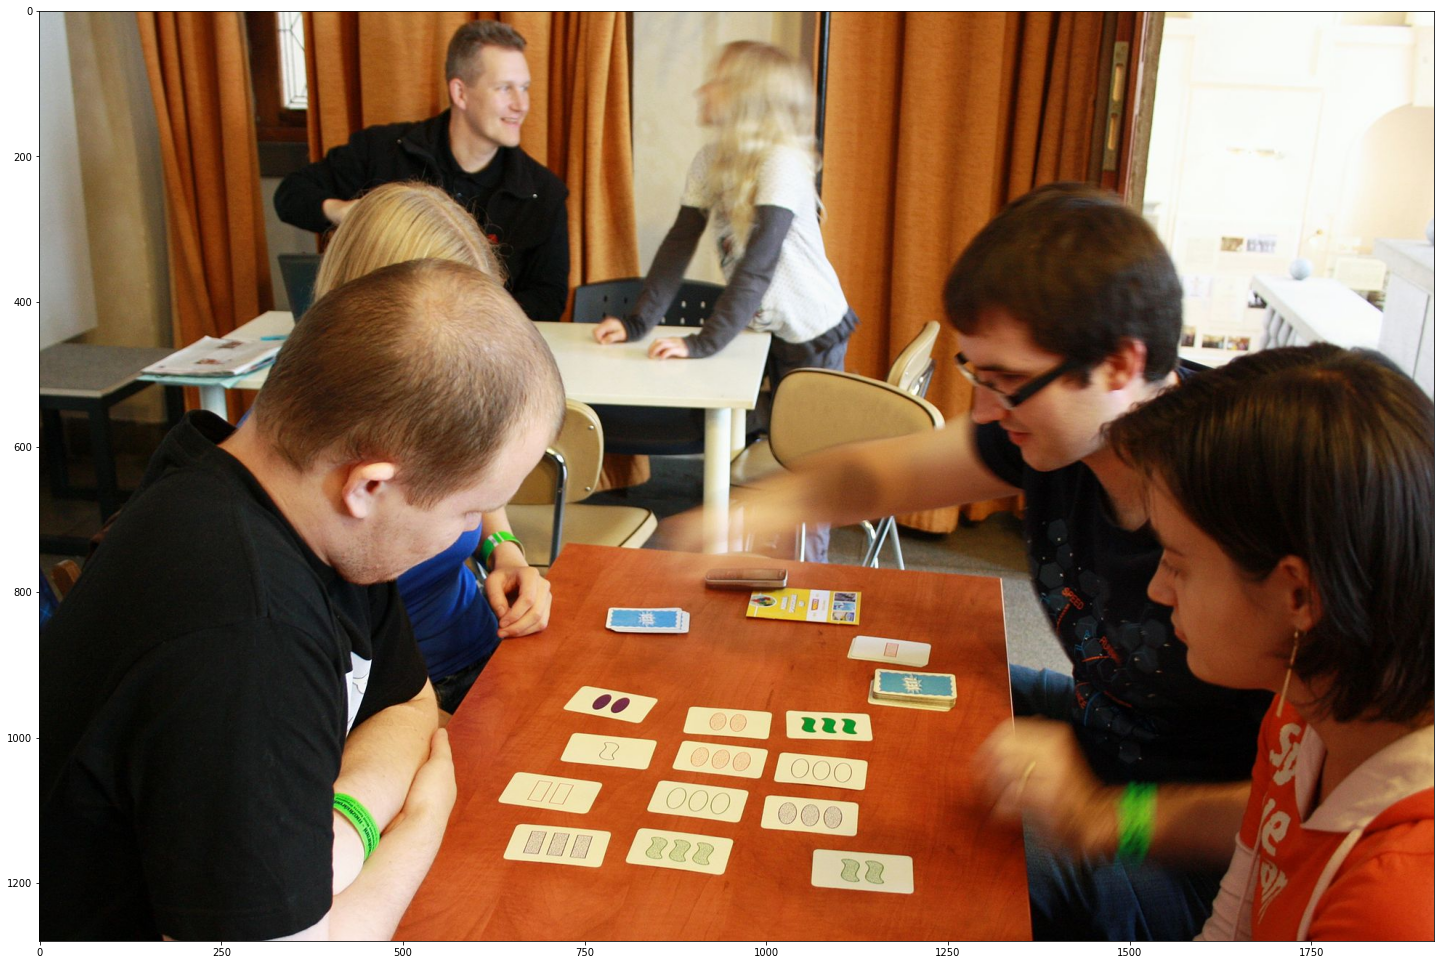

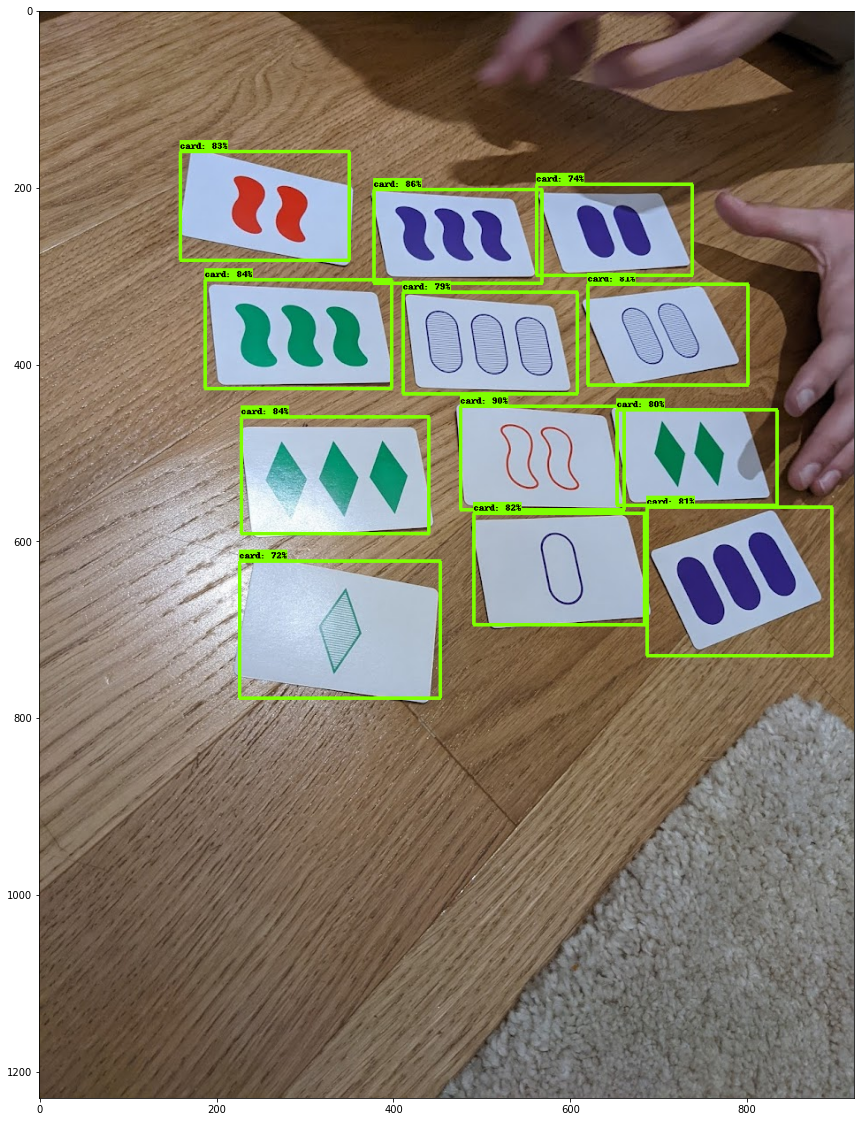

In [ ]:
def eval(detection_model):
  # TODO abstract data loading into function
  test_image_dir = 'data/test'
  test_images_np = []
  for file in os.listdir(test_image_dir):
    path = os.path.join(test_image_dir, file)
    if not os.path.isfile(path):
      continue
    print(path)
    test_images_np.append(np.expand_dims(
        load_image_into_numpy_array(path), axis=0))

  # Again, uncomment this decorator if you want to run inference eagerly
  @tf.function
  def detect(input_tensor):
    """Run detection on an input image.

    Args:
      input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.

    Returns:
      A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
        and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

  # Note that the first frame will trigger tracing of the tf.function, which will
  # take some time, after which inference should be fast.

  label_id_offset = 1
  for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    # print({k: v.shape for k,v in detections.items()})
    
    # Perform non-max suppression
    print({k : v.shape for k,v in detections.items()})
    # selected_i = tf.image.non_max_suppression(
    #   detections['detection_boxes'][0],
    #   detections['detection_scores'][0],
    #   20,
    #   0.3
    # )
    # detections = {k: tf.gather(v[0], selected_i) for k,v in detections.items() if k.startswith('detection')}

    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, 
        figsize=(25, 20), 
        # image_name="gif_frame_" + ('%02d' % i) + ".jpg"
    )
    # break

eval(detection_model)